# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on <a href="https://en.wikipedia.org/wiki/Central_limit_theorem">Wikipedia's</a> page about the CLT carefully, it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also <a href="https://en.wikipedia.org/wiki/Normality_test">other ways<a>
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****


# 1. Preparation

In [1]:
## Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")
plt.style.use('seaborn-notebook')

## import data
df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
## Helpfer functions
def ecdf(obs):
    """Compute ECDF(Empirical Cumulative Distribution Function) for a 1-d array of measurements.   
    INPUT:  obs: observations of 1d array or list
    Output:  1) x: sorted 1d array
             2) y: cumulative probability of same order as x"""
    
    ## numbber of data points
    n = len(obs)
    
    ## x-axis: random variable 
    x = np.sort(obs)
    
    ## y-axis: fraction of data or cumulative probability
    y = np.arange(1, n+1) / n
    
    return x, y


def draw_bs_reps(obs, func, size=1):
    """Draw bootstrap replicates by given function  
    INPUT: 1) obs: observations of 1d array or list
           2) func: function to generate replicate
           3) size: size of return array of replicates
    OUTPUT: 1d array of repllicates
    """
    
    ## helpfer function that generate replicate of a sample
    def bootstrap_replicate_1d(obs, func):
        return func(np.random.choice(obs, size=len(obs)))
    
    ## initialize array of replicates of size
    bs_replicates = np.empty(size)
    
    ## generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(obs, func)
        
    return bs_replicates

# 2. Data Inspection

In [3]:
## Check missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


No missing values, two numerical & continuous random variables (temperature & heart_rate) and one categorical random variable (gender). Howeer let us not forget that we are interested in __temperature__.

In [4]:
## take a look at the head of dataframe
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [5]:
## descriptive statistics
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [6]:
## split dataframe for easiness
temp_male = df[df['gender']=='M'].temperature
temp_female = df[df['gender']=='F'].temperature

In [7]:
temp_male.describe()

count    65.000000
mean     98.104615
std       0.698756
min      96.300000
25%      97.600000
50%      98.100000
75%      98.600000
max      99.500000
Name: temperature, dtype: float64

In [8]:
temp_female.describe()

count     65.000000
mean      98.393846
std        0.743488
min       96.400000
25%       98.000000
50%       98.400000
75%       98.800000
max      100.800000
Name: temperature, dtype: float64

### Histogram of temperature by gender

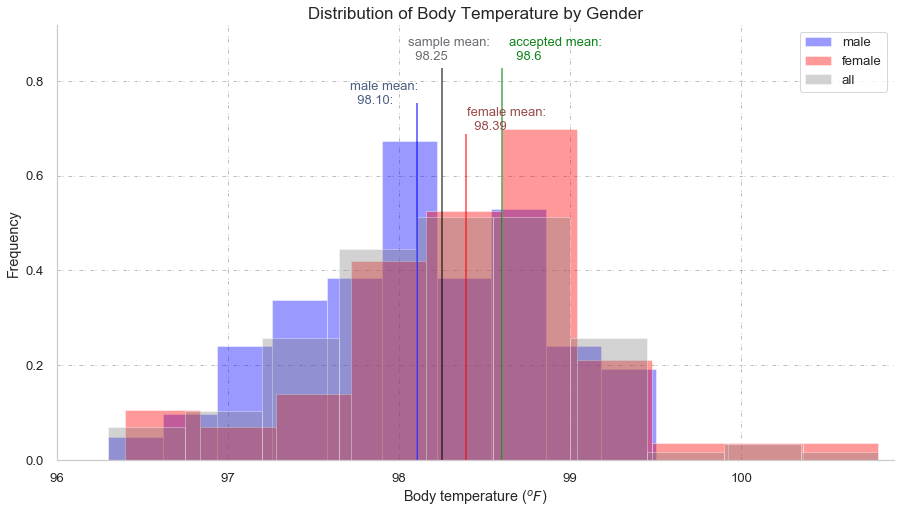

In [9]:
fig = plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", font_scale=1.2)

## make histogram of male and female
ax1 = temp_male.hist(bins=10, density=True, alpha=0.4, color='blue')
ax2 = temp_female.hist(bins=10, density=True, alpha=0.4, color='red')
ax3 = df['temperature'].hist(bins=10, density=True, alpha=0.35, color='grey')
plt.legend(['male', 'female', 'all'], loc='best')

## add vlines
ax1.vlines(np.mean(temp_male), 0,0.82, transform=ax1.get_xaxis_transform(), alpha=0.7, color='blue')
ax2.vlines(np.mean(temp_female), 0,0.75, transform=ax2.get_xaxis_transform(), alpha=0.7, color='red')
ax3.vlines(np.mean(df['temperature']), 0,0.9, transform=ax3.get_xaxis_transform(), alpha=0.7, color='black')
ax3.vlines(98.6, 0,0.9, transform=ax3.get_xaxis_transform(), alpha=0.7, color='green')

## add text
ax1.text(0.35, 0.82, 'male mean:\n  {:.2f}:'.format(np.mean(temp_male)), 
         transform=ax1.transAxes, color='#4a5f82', fontsize=13);
ax2.text(0.49, 0.76, 'female mean:\n  {:.2f}'.format(np.mean(temp_female)), 
         transform=ax1.transAxes, color='#994a4a', fontsize=13);
ax3.text(0.42, 0.92, 'sample mean:\n  {:.2f}'.format(np.mean(df['temperature'])), 
         transform=ax1.transAxes, color='#6a6d72', fontsize=13);
ax3.text(0.54, 0.92, 'accepted mean:\n  98.6', transform=ax1.transAxes, color='#0f841b', fontsize=13);
plt.margins(0.02)
plt.xticks(range(96, 101));

## remove spines
for axis in ['right', 'top']:
    ax2.spines[axis].set_visible(False)

## set grid (reference: https://matplotlib.org/gallery/lines_bars_and_markers/linestyles.html)
ax2.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)

## set title, label
plt.title('Distribution of Body Temperature by Gender', fontsize=17)
plt.xlabel('Body temperature ($^oF$)')
plt.ylabel('Frequency')

## save
plt.savefig('images/00_hist_gender.JPG');

### beeswarmplot

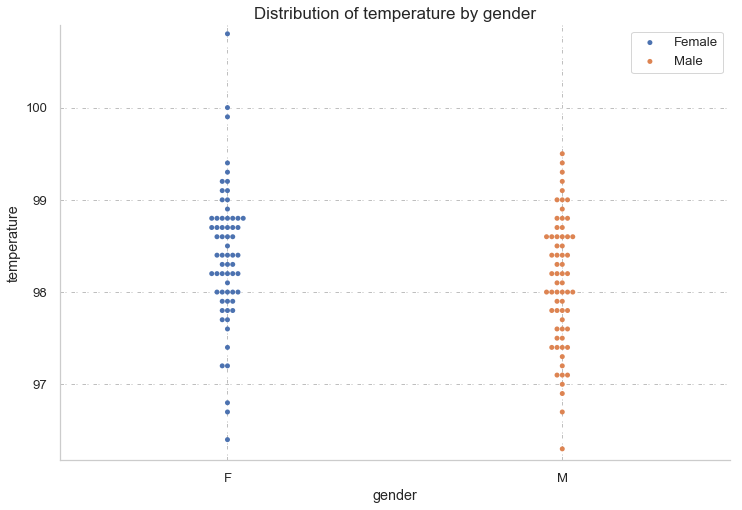

In [10]:
fig = plt.figure(figsize = (12,8))
ax = sns.swarmplot(x='gender', y='temperature', data= df)

plt.margins(0.02)
ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)
ax.legend(['Female','Male'])
ax.set_title('Distribution of temperature by gender', fontsize=17)
sns.despine(right=True, top=True)
plt.savefig('images/01_swarmplot.JPG')

<table>
<col />
<thead>
<tr>
	<th> </th>
	<th>All</th>
	<th>Male</th>
	<th>Female</th>
</tr>
</thead>
<tbody>
<tr>
	<th>mean</th>
	<td>98.249231</td>
	<td>98.104615</td>
	<td>98.393846</td>
</tr>
<tr>
	<th>std</th>
	<td>0.733183</td>
	<td>0.698756</td>
	<td>0.743488</td>
</tr>
<tr>
	<th>count</th>
	<td>130</td>
	<td>65</td>
	<td>65</td>
</tr>
</tbody>
</table>

First, overall mean temperature is at 98.25 $^oF$ less than 98.6 $^oF$ by 0.35 that is widely accepted. Also, we can see mean temperature of female is higher than that of male by 0.289 $^oF$ and female temperature is more spread than male's. Whit this in mind, let us start analysis.

# Q1. Is the Distribution of the Body Temperatures Normal?

### Sample the normal distribution using the sample's statistics

In [11]:
## Using sample's mean and standard deviation, let us generate the normal distribution of size 10,000
normal_dist_all = np.random.normal(np.mean(df['temperature']), np.std(df['temperature']), 10000)

## Using "male" sample's mean and standard deviation, let us generate the normal distribution of size 10,000
normal_dist_male = np.random.normal(np.mean(temp_male), np.std(temp_male), 10000)

## Using "female" sample's mean and standard deviation, let us generate the normal distribution of size 10,000
normal_dist_female = np.random.normal(np.mean(temp_female), np.std(temp_female), 10000)

### Plot the sample's distribution against sampled normal distribution

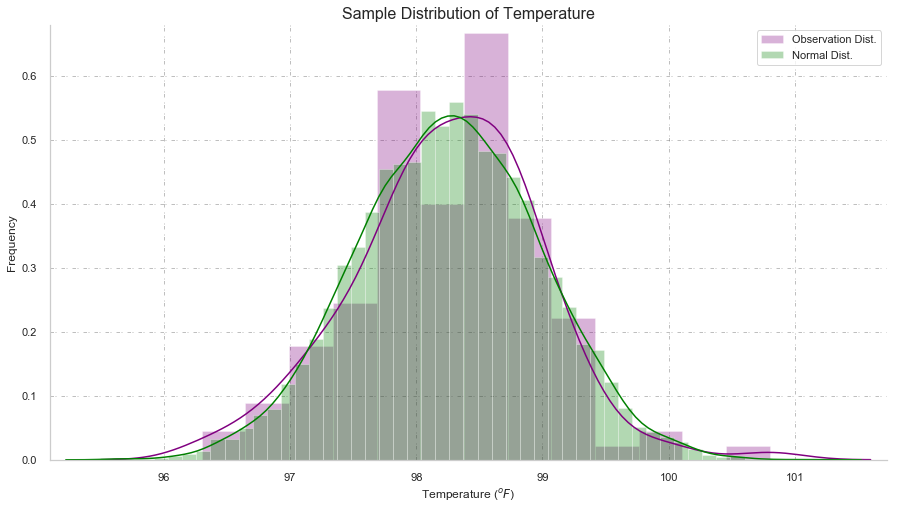

In [12]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", font_scale=1)

ax1 = sns.distplot(df['temperature'], color='purple', hist_kws=dict(alpha=0.3))
ax2 = sns.distplot(normal_dist_all, color='green', hist_kws=dict(alpha=0.3))

plt.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)
plt.margins(0.02)

plt.legend(['Observation Dist.', 'Normal Dist.'])
plt.title('Sample Distribution of Temperature', fontsize=16)
plt.xlabel('Temperature ($^oF$)')
plt.ylabel('Frequency')

sns.despine(right=True, top=True)
plt.savefig('images/02_normality_all.JPG');

### Visualize ECDF (Empirical CDF)

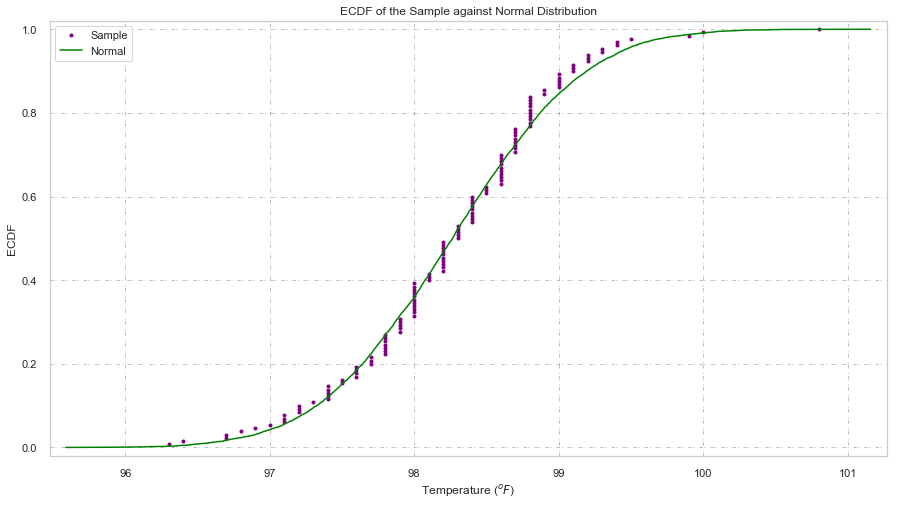

In [13]:
## call ecdf function
sample_x, sample_y = ecdf(df['temperature'])
normal_x, normal_y = ecdf(normal_dist_all)

plt.figure(figsize=(15, 8))
plt.plot(sample_x, sample_y, marker='.', markersize=8, linestyle='none', color='purple')
plt.plot(normal_x, normal_y, color='green')

plt.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)
plt.margins(0.02)

plt.legend(['Sample', 'Normal'], loc='best')
plt.title('ECDF of the Sample against Normal Distribution')
plt.ylabel('ECDF')
plt.xlabel('Temperature ($^oF$)')
plt.savefig('images/03_ecdf_all.JPG');

With graphical methods, our sample distribution does look normal. To confirm this, let us test normality using scipy.stat.normaltest.

In [14]:
## Define signmificance level: 5%
alpha = 0.05

## p: a 2-sided chi squared probability for the hypothesis test.
k2, p = stats.normaltest(df['temperature'])

## null hypothesis: sample distribution is from a normal distribution
print("p-value: {}".format(p))
if p < alpha: 
    print("The null hypothesis can be rejected: sample distribution is failed in normality test")
else: 
    print("The null hypothesis cannot be rejected: sample distribution passed normality test")

p-value: 0.2587479863488254
The null hypothesis cannot be rejected: sample distribution passed normality test


From graphs and normality test, we can safely presume our __sample of body temperature is normal__. Let us go one step further and see if sub-sample by gender shows the same result.

### Perform same graphical analysis on male/female sub-sample

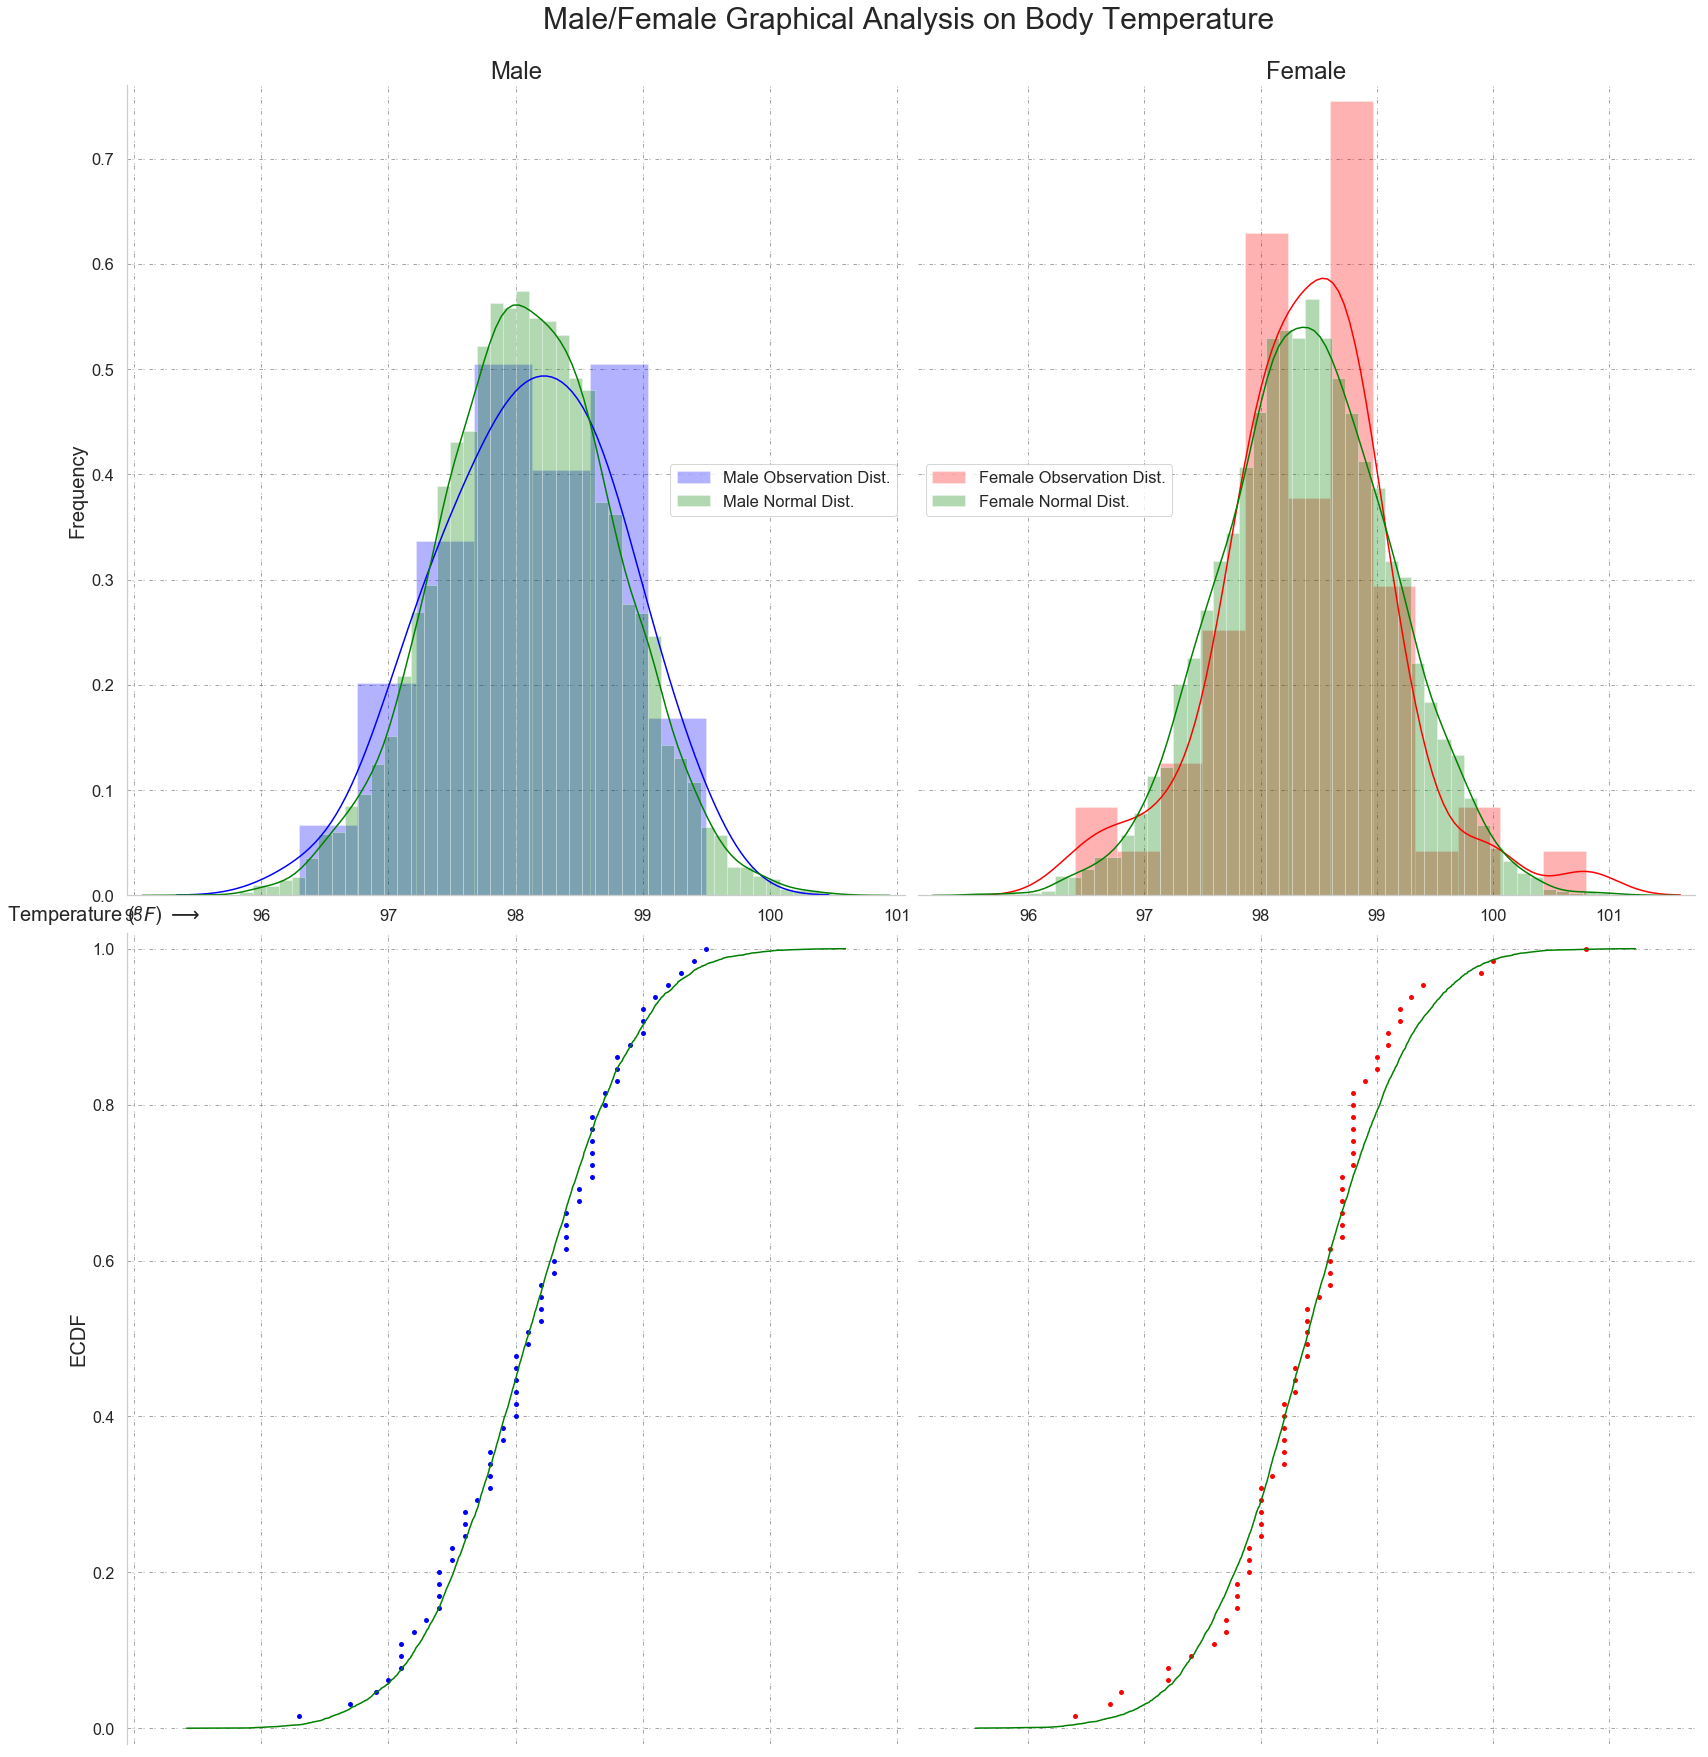

In [15]:
## call ecdf function
male_x, male_y = ecdf(temp_male)
male_normal_x, male_normal_y = ecdf(normal_dist_male)
female_x, female_y = ecdf(temp_female)
female_normal_x, female_normal_y = ecdf(normal_dist_female)

sns.set(style="whitegrid", font_scale=1.5)
fig, axs = plt.subplots(2, 2, figsize=(24, 24))
fig.suptitle("Male/Female Graphical Analysis on Body Temperature", fontsize=30, x=.53, y=1.02)

## male column: distribution, ecdf
## ax1: male temperature distribution
ax1 = plt.subplot(2,2,1)
sns.distplot(temp_male, ax=ax1, color='blue', hist_kws=dict(alpha=0.3))
sns.distplot(normal_dist_male, ax=ax1, color='green', hist_kws=dict(alpha=0.3))
ax1.set_xlabel('')
ax1.set_title('Male', size=24)
ax1.set_xlabel("Temperature ($^oF$) $\longrightarrow$", fontsize=20)
ax1.xaxis.set_label_coords(-.03, -.01)
ax1.set_ylabel("Frequency", fontsize=20)
ax1.legend(['Male Observation Dist.', 'Male Normal Dist.'], loc='center right')
sns.despine(right=True, top=True, ax=ax1)

## ax3: male temperature ecdf
ax3 = plt.subplot(2,2,3, sharex=ax1)
ax3.plot(male_x, male_y, marker='.', markersize=10, linestyle='none', color='blue')
ax3.plot(male_normal_x, male_normal_y, color='green')
ax3.tick_params(labelbottom=False, labelleft=True, labelsize=16)
ax3.set_xlabel('')
ax3.set_ylabel("ECDF", fontsize=20)
sns.despine(right=True, top=True, bottom=True, ax=ax3)


## female column: distribution, ecdf
## ax2: female temperature distribution
ax2 = plt.subplot(2,2,2, sharey=ax1)
sns.distplot(temp_female, ax=ax2, color='red', hist_kws=dict(alpha=0.3))
sns.distplot(normal_dist_female, ax=ax2, color='green', hist_kws=dict(alpha=0.3))
ax2.set_xlabel('')
ax2.tick_params(labelleft=False)
ax2.set_title('Female', size=24)
ax2.legend(['Female Observation Dist.', 'Female Normal Dist.'], loc='center left')
sns.despine(left=True, top=True, ax=ax2)

## ax4: female temperature ecdf
ax4 = plt.subplot(2,2,4, sharex=ax2, sharey=ax3)
ax4.plot(female_x, female_y, marker='.', markersize=10, linestyle='none', color='red')
ax4.plot(female_normal_x, female_normal_y, color='green')
ax4.tick_params(labelbottom=False, labelleft=False, labelsize=14)
ax4.set_xlabel('')
sns.despine(left=True, top=True, bottom=True, ax=ax4)

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
    ax.margins(0.02)
plt.tight_layout(w_pad=-0.05, h_pad=0.1)
plt.savefig('images/04_graphical_gender.JPG');

In [16]:
## Define signmificance level: 5%
alpha = 0.05

## p: p-value
k2_male, p_male = stats.normaltest(temp_male)
k2_female, p_female = stats.normaltest(temp_female)

## null hypothesis: sample distribution is from a normal distribution
print("<Male>")
print("p-value: {}".format(p_male))
if p < alpha: 
    print("The null hypothesis can be rejected: sample distribution of male is failed in normality test")
else: 
    print("The null hypothesis cannot be rejected: sample distribution of male passed normality test")
print()    
print("<Female>")
print("p-value: {}".format(p_female))
if p < alpha: 
    print("The null hypothesis can be rejected: sample distribution of female is failed in normality test")
else: 
    print("The null hypothesis cannot be rejected: sample distribution of female passed normality test")

<Male>
p-value: 0.6404399074569123
The null hypothesis cannot be rejected: sample distribution of male passed normality test

<Female>
p-value: 0.09369419389856404
The null hypothesis cannot be rejected: sample distribution of female passed normality test


<table>
<col />
<thead>
<tr>
	<th>Sample</th>
	<th>p-value</th>
	<th>Result</th>
</tr>
</thead>
<tbody>
<tr>
	<td>Entire sample</td>
	<td>0.258</td>
	<td>Normally Distributed</td>
</tr>
<tr>
	<th>Male subsample</th>
	<td>0.640</td>
	<td>Normally Distributed</td>
</tr>
<tr>
	<th>Female subsample</th>
	<td>0.094</td>
	<td>Normally Distributed</td>
</tr>
</tbody>
</table>

We just confirmed that even both sub-samples of male and female passed nomality test; therefore, we can presume __sample is normally distributed regardless of gender__. However, one might notice that female subsample barely passed nomality test with p-value of 0.09 given significance level ($\alpha$) was 0.05 and compred to two other p-values. This means someone could reject the null hypothesis depending on designated significance level.

# Q2. Is the sample size large? Are the observations independent?
Statistical independence implies that the occurrence of one event does not affect the probability of the other. Another way of saying is that the occurrence of one event should not change your beliefs about the other. Based on this, we can assume **the observations are independent** in that person A's temperature does not affect at all person B's temperature. 

Although the Central Limit Theorem (CLT) tells us that we can use a Normal model to think about the behavior of sample means when the sample size is large enough, it does not tell us how large that should be. If the population is very skewed, you will need a pretty large sample size to use the CLT, however if the population is unimodal and symmetric, which is our case, even small samples are acceptable. In general a sample size of 30 is considered sufficient if the sample is unimodal. Therefore, **our sample size can be considered large**. 

# Q3. Is the true population mean really 98.6 degrees F?

Since we believe body temperature is from same distribution of mean 98.6 $^oF$ (H$_o$), we use __one-sample test__ here. To alternative conduct hypothesis test, we can choose __z statistic__ in that we have sample sizes over 30. Note that when sampel size is large enough (> 30), t statistic and z statistic should give very similar result. Also, from previous questions, we suppose sample distribution follows normal distribution and meets CLT conditions (randomization condition, independence assumption, 10% condition, and sample size assumption). 

### Conduct bootstrap hypothesis test

p-value: 0.0
The null hypothesis can be rejected: true population mean is not likely 98.6 F
95% confidence interval of bootstrap distribution is [98.474, 98.726]


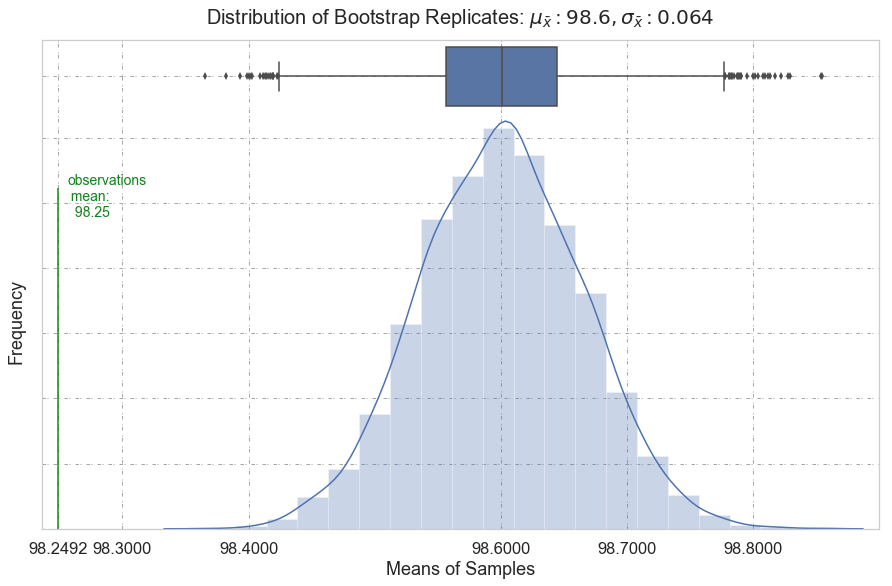

In [17]:
## Observations mean
sample_mean = np.mean(df['temperature'])

## bootstrap the sample 10,000 times and calculate the mean of each sample
## Also, move sample distribution so the mean is located at 98.6 (This is thanks to CLT)
bs_replicates = draw_bs_reps(df['temperature'], np.mean, 10000) - sample_mean + 98.6

## define significance level: 0.05
alpha = 0.05
## Calculate p_value
p_value = np.sum(bs_replicates < sample_mean) / len(bs_replicates)

## null hypothesis: true population mean is 98.6 degrees F
print("p-value:", p_value)
if p_value < alpha:
    print("The null hypothesis can be rejected: true population mean is not likely 98.6 F")
else:
    print("The null hypothesis cannot be rejected: true population mean is likely 98.6 F")

## Calculate 95% confidence interval of bs distribution
left, right = np.percentile(bs_replicates, [2.5, 97.5])
print("95% confidence interval of bootstrap distribution is [{:.3f}, {:.3f}]".format(left, right))

## visualization
f, (ax_box, ax_hist) = plt.subplots(2, figsize = (15,9), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

ax1 = sns.distplot(bs_replicates, bins = 20, ax = ax_hist, hist_kws=dict(alpha=0.3))
ax2 = sns.boxplot(bs_replicates, hue = 0.5, ax = ax_box)

ax1.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax1.text(0.03, 0.75, 'observations\n mean:\n  {:.2f}'.format(sample_mean), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
plt.title(r'Distribution of Bootstrap Replicates: $\mu_{\bar{x}}: 98.6, \sigma_{\bar{x}}: 0.064$', 
          y = 1.2, fontsize=20)
plt.xlabel('Means of Samples')
plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)
ax1.vlines(sample_mean, 0,0.82, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
ax1.set_xticks([sample_mean, 98.3, 98.4, 98.6, 98.7, 98.8])
ax1.yaxis.set_ticklabels([])

for ax in [ax1, ax2]:
    ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
    ax.margins(0.02)
plt.savefig('images/05_bootstrap.JPG')

Based on bootstrap hypothesis test, our p-value is very small (<<0); thus, p-value is statistically (very) significant and we reject the null hypothesis that true population mean of body temperature is 98.6. That is, __true population mean of body temperature is NOT 98.6 F__.

### Conduct Z-test
Since the sample distribution is considered normal and its size is large enough, I can apply CLT. I will conduct z-test to see if it gives different result.

p-value: 0.0
The null hypothesis can be rejected: true population mean is not likely 98.6 F
95% confidence interval of normal distribution is [98.474, 98.725]


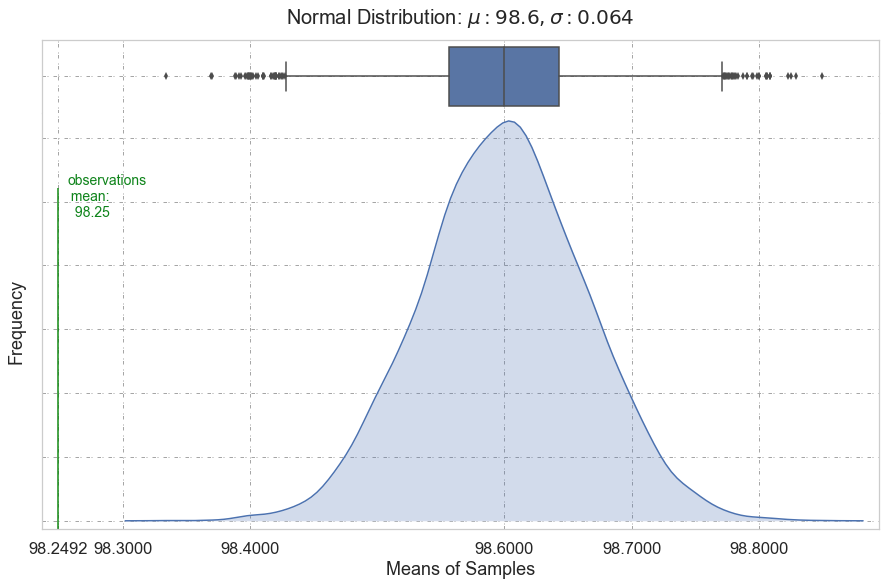

In [18]:
mu = 98.6 # population mean
x_bar = np.mean(df['temperature']) # sample mean: 98.25
s = np.std(df['temperature']) # sample standard deviation: 0.733
sigma = s / np.sqrt(len(df)) # standard error of the mean (SEM)

## Using population mean(98.6) and standard deviation of the sample, let us generate the normal distribution of size 10,000
normal_dist_pop = np.random.normal(mu, sigma, 10000)

## find z-score of the sample mean (98.25)
z_score = (x_bar - mu) / sigma 

## define significance level: 0.05
alpha = 0.05

## p-value
p_value = np.sum(normal_dist_pop < x_bar) / len(normal_dist_pop)

## null hypothesis: true population mean is 98.6 degrees F
print("p-value:", p_value)
if p_value < alpha:
    print("The null hypothesis can be rejected: true population mean is not likely 98.6 F")
else:
    print("The null hypothesis cannot be rejected: true population mean is likely 98.6 F")

## find 95% confidence interval
left, right = np.percentile(normal_dist_pop, [2.5, 97.5])
print("95% confidence interval of normal distribution is [{:.3f}, {:.3f}]".format(left, right))

## visualization
f, (ax_box, ax_hist) = plt.subplots(2, figsize = (15,9), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

ax1 = sns.distplot(normal_dist_pop, hist=False, ax = ax_hist, kde_kws={'shade':True})
ax2 = sns.boxplot(normal_dist_pop, hue = 0.5, ax = ax_box)

ax1.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax1.text(0.03, 0.75, 'observations\n mean:\n  {:.2f}'.format(sample_mean), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
plt.title(r'Normal Distribution: $\mu: {}, \sigma: {:.3f}$'.format(mu, sigma), y = 1.2, fontsize=20)
plt.xlabel('Means of Samples')
plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)
ax1.vlines(sample_mean, 0,0.82, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
ax1.set_xticks([sample_mean, 98.3, 98.4, 98.6, 98.7, 98.8])
ax1.yaxis.set_ticklabels([])

for ax in [ax1, ax2]:
    ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
    ax.margins(0.02)
plt.savefig('images/06_ztest.JPG')

z-test just gave the almost same result as bootstrap hypothesis test! Therefore, according to z-test, we can reject our null hypothesis that true population mean really 98.6 $^oF$. Given p-value is very negligible, it strongly implies __true population mean body temperature is NOT 98.6 $^oF$__.

# Q4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

The t-test is based on Student’s t-distribution. On the contrary, z-test relies on the assumption that the distribution of sample means is normal. Both student’s t-distribution and normal distribution appear alike, as both are symmetrical and bell-shaped. However, they differ in the sense that in a t-distribution, there is less space in the center and more in the tails. 

Z-test is used to when the sample size is large, i.e. n > 30, and t-test is appropriate when the size of the sample is small, in the sense that n < 30. Therefore, __it is wise to use t-test with a small sample of size 10__. However, for the sake of exercise, let us try both and compare the results.

### Conduct bootstrap & z / t test

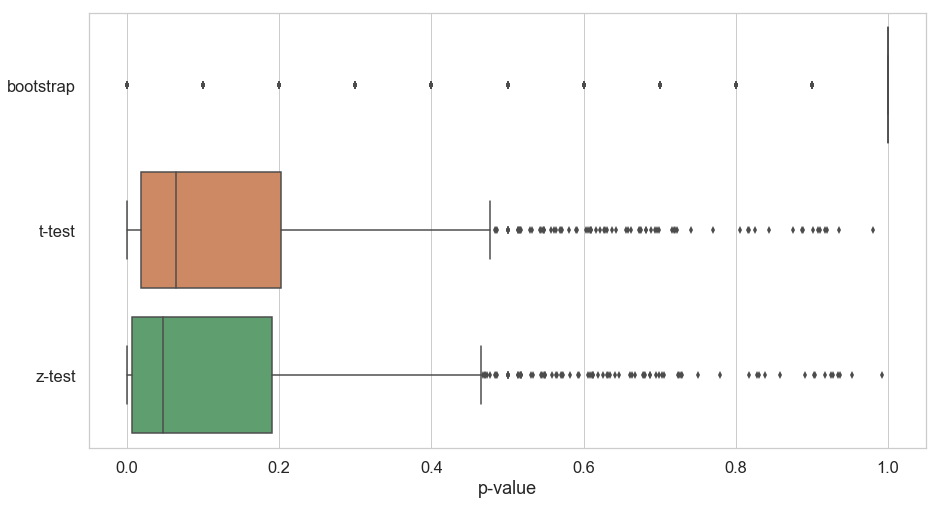

In [19]:
## mu = 98.6 # population mean
np.random.seed(614)

pts = []
pzs = []
pbs = []

##perform experiment 10 times
for i in range(1000):
    ## Draw a random 10 samples for p, t
    samples = np.random.choice(df['temperature'], size=10)
    ## bootstrap the sample 10 times and calculate the mean of each sample
    ## Also, move sample distribution so the mean is located at 98.6 (This is thanks to CLT)
    bs_replicates = draw_bs_reps(df['temperature'], np.mean, 10) - sample_mean + 98.
   
    ## sample mean
    x_bar = np.mean(samples)
    ## sample standard deviation
    s = np.std(samples)
    ## SE (standard deviation of sample mean)
    sigma = s/np.sqrt(10)
    
    ## bootstrap p-value
    p_b = np.sum(bs_replicates < x_bar) / len(bs_replicates)
    ## perform t-statistic
    t = (x_bar - mu) / sigma
    p_t = stats.t.cdf(t, df=10-1) # we assume independent observations, df:degree of freedom: 9
    ## perform z-statistics
    z = (x_bar - mu)  / sigma
    p_z = stats.norm.cdf(z)
    
    pbs.append(p_b)
    pts.append(p_t)
    pzs.append(p_z)
    
## visualize
fig = plt.figure(figsize=(15, 8))
df_b = pd.DataFrame(pbs, columns=['p-value'])
df_b['kind'] = 'bootstrap'
df_t = pd.DataFrame(pts, columns=['p-value'])
df_t['kind'] = 't-test'
df_z = pd.DataFrame(pzs, columns=['p-value'])
df_z['kind'] = 'z-test'
df_score = pd.concat([df_b, df_t, df_z], axis=0)

ax = sns.boxplot(x='p-value', y='kind', data=df_score)
ax.set_ylabel('');

Above boxplot shows, after 1000 times of sampling, p-values from z-test is skewed toward lower values. 
The t‐distribution is used as an alternative to the normal distribution when sample sizes are small in order to estimate confidence or determine critical values that an observation is a given distance from the mean. It is a consequence of the sample standard deviation being a biased or underestimate (usually) of the population standard deviation. If you recall tails of t-distribution are fatter than those of z-distribution, this result is not surprising. 
Last but not least, we observe p-value variates a lot at each iteration which is not desirable, therefore, I conclude that small size sample test is better avoided, if possible.

As for bootsrap distribution, p-value shows extreme trend, which is hardly reliable. The bootstrap method is only useful if your sample follows more or less the same distribution as the original population. In order to be certain this is the case you need to make your sample size large enough. In this case sample size n=10 is obviously not large enough. 

# Q5. At what temperature should we consider someone's temperature to be "abnormal"?
Before we delve into the problem, let us set our tactics clear: I will consider temperature outside 95% confidence interval which is equal to saying I define abnomral temperture as one belongs to 5% of the population; or one that is more than 2 standard deviation above or below the mean.

### Generate boostrap distribution

95% confidence interval of bootstrap distribution is [98.120, 98.375]


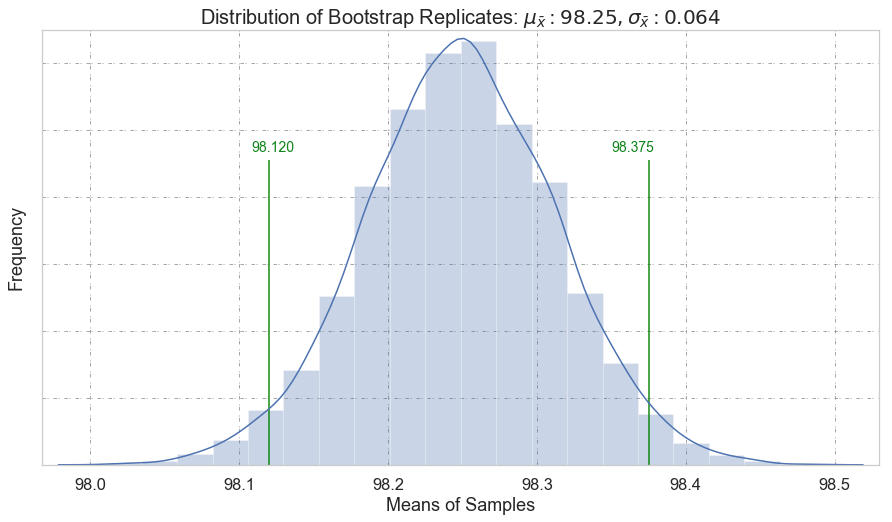

In [20]:
## Observations mean
x_bar = np.mean(df['temperature'])

## bootstrap the sample 10,000 times and calculate the mean of each sample
bs_replicates = draw_bs_reps(df['temperature'], np.mean, 10000)

## Calculate 95% confidence interval of bs distribution
left, right = np.percentile(bs_replicates, [2.5, 97.5])
print("95% confidence interval of bootstrap distribution is [{:.3f}, {:.3f}]".format(left, right))

## visualization
plt.figure(figsize=(15,8))
ax1 = sns.distplot(bs_replicates, bins = 20, hist_kws=dict(alpha=0.3))

plt.title(r'Distribution of Bootstrap Replicates: $\mu_{\bar{x}}: 98.25, \sigma_{\bar{x}}: 0.064$', fontsize=20)
plt.xlabel('Means of Samples')
plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)
ax1.yaxis.set_ticklabels([])

ax1.text(0.25, 0.72, '{:.3f}'.format(left), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
ax1.text(0.68, 0.72, '{:.3f}'.format(right), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
ax1.vlines(left, 0,0.7, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
ax1.vlines(right, 0,0.7, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)

ax1.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
ax1.margins(0.02)
plt.savefig('images/07_bootstrap_q5.JPG')

### Generate z-distribution (normal)

95% confidence interval of z-distribution is [98.124, 98.378]


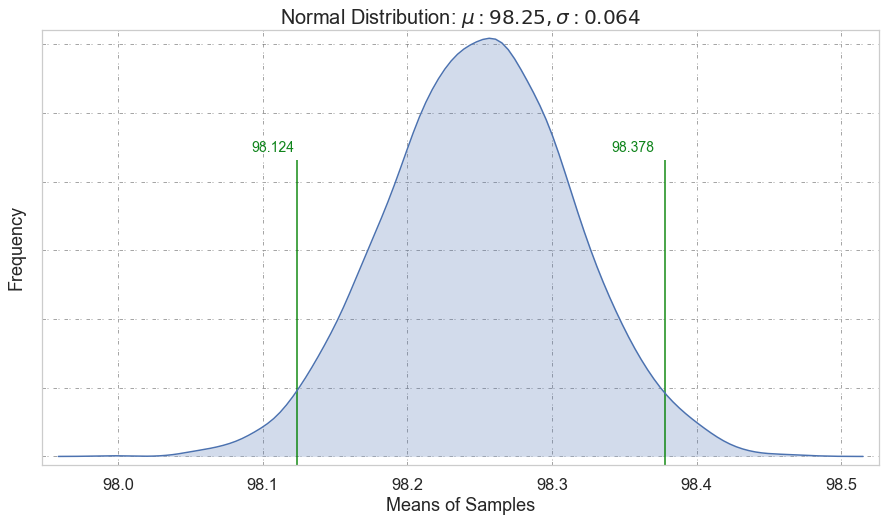

In [21]:
x_bar = np.mean(df['temperature']) # sample mean: 98.25
s = np.std(df['temperature']) # sample standard deviation: 0.733
sigma = s / np.sqrt(len(df)) # standard error of the mean (SEM)

## Using population mean(98.25) and standard deviation of the sample, let us generate the normal distribution of size 10,000
normal_dist_pop = np.random.normal(x_bar, sigma, 10000)

## find 95% confidence interval
left, right = np.percentile(normal_dist_pop, [2.5, 97.5])
print("95% confidence interval of z-distribution is [{:.3f}, {:.3f}]".format(left, right))

## visualization
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(normal_dist_pop, shade=True)

plt.title(r'Normal Distribution: $\mu: {:.2f}, \sigma: {:.3f}$'.format(x_bar, sigma), fontsize=20)
plt.xlabel('Means of Samples')
plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)
ax1.yaxis.set_ticklabels([])

ax1.text(0.25, 0.72, '{:.3f}'.format(left), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
ax1.text(0.68, 0.72, '{:.3f}'.format(right), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
ax1.vlines(left, 0,0.7, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
ax1.vlines(right, 0,0.7, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)

ax1.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
ax1.margins(0.02)
plt.savefig('images/08_zdist_q5.JPG')

### Generate t-distribution

95% confidence interval of t-distribution is [98.124, 98.375]


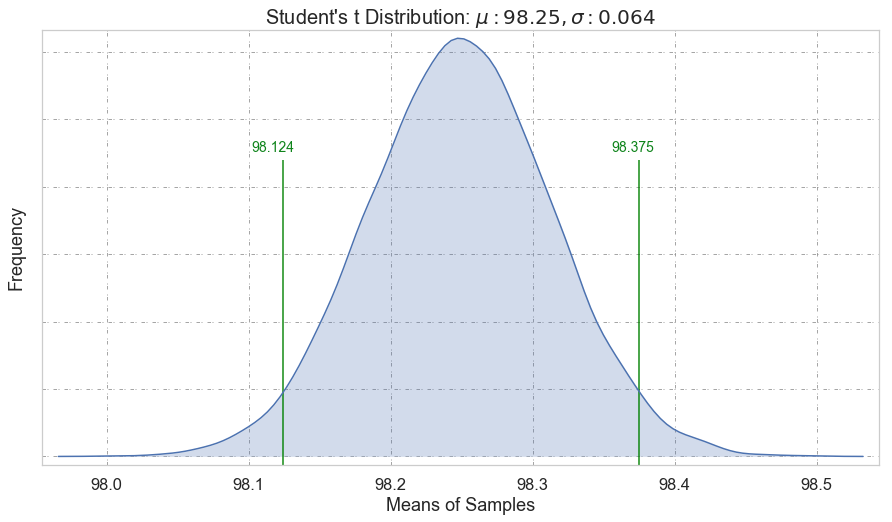

In [22]:
## Using population mean(98.25) and standard deviation of the sample, let us generate the student's t distribution of size 10,000
t_dist = stats.t.rvs(df=len(df)-1, loc=x_bar, scale=sigma, size=10000)

## find 95% confidence interval
left, right = np.percentile(t_dist, [2.5, 97.5])
print("95% confidence interval of t-distribution is [{:.3f}, {:.3f}]".format(left, right))

## visualization
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(t_dist, shade=True)
plt.title(r"Student's t Distribution: $\mu: {:.2f}, \sigma: {:.3f}$".format(x_bar, sigma), fontsize=20)
plt.xlabel('Means of Samples')
plt.ylabel('Frequency')
ax1.yaxis.set_ticklabels([])

ax1.text(0.25, 0.72, '{:.3f}'.format(left), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
ax1.text(0.68, 0.72, '{:.3f}'.format(right), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
ax1.vlines(left, 0,0.7, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
ax1.vlines(right, 0,0.7, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)

ax1.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
ax1.margins(0.02)
plt.savefig('images/09_tdist_q5.JPG')

When you see all 3 95% confidence intervals, it is \[98.120, 98.375], \[98.124, 98.378], \[98.124, 98.375]. This result confirms that all three distributions show almost same normal distribution. Thererfore, __I define abnormal temperature as lower than 98.120 $^oF$ and higher than 98.375 $^oF$__ when assuming population mean temperature is 98.25 $^oF$.

# Q6. Is there a significant difference between males and females in normal temperature?
For this question, __null hypothesis (H$_o$) is: there is not significant difference between two genders in normal temperature__, and in order to perform hypothesis test, we need to conduct __two-sample bootstrap hypothesis test__ in that we have subsamples composed of only male and female and they are considered normal from Q1, Q2.

### Two-sample bootstrap hypothesis test

In [23]:
## mean of the entire sample
mu = np.mean(df['temperature'])
## mean of the male sample
mmean = np.mean(temp_male)
## mean of the female sample
fmean = np.mean(temp_female)
## std of the male sample
mstd = np.std(temp_male)
## std of the female sample
fstd = np.std(temp_female)

## Calculate the difference in sample means
mean_diff = fmean - mmean

## bootstrap the sample 10,000 times and calculate the mean of each male and female sample
mbs_replicates = draw_bs_reps(temp_male, np.mean, 10000) - mmean + mu
fbs_replicates = draw_bs_reps(temp_female, np.mean, 10000) - fmean + mu

## replicates of mean difference
bs_replicates = fbs_replicates - mbs_replicates

## define significance level: 0.05
alpha = 0.05
## Calculate p_value
p_value = np.sum(bs_replicates > mean_diff) / len(bs_replicates)

## null hypothesis: there is not significant difference between two genders in normal temperature
print("p-value:", p_value)
if p_value < alpha:
    print("The null hypothesis can be rejected: there might be significant difference between two genders in normal temperature")
else:
    print("The null hypothesis cannot be rejected: there is not significant difference between two genders in normal temperature")

p-value: 0.0115
The null hypothesis can be rejected: there might be significant difference between two genders in normal temperature


Based on two-sample bootstrap hypothesis test, it likable that there exists significant difference between two gender groups in normal temperature and thus we can conclude that average body temperature of male and female is NOT same. 